In [2]:
import numpy as np
from matplotlib import pyplot
from sklearn.datasets import fetch_openml
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from scipy.io import arff
import pickle

In [11]:
# Load the .arff file
loaded = arff.loadarff('../connect-4.arff')

# Convert to a numpy array
data = np.asarray(loaded[0].tolist(), dtype=np.float32)
X = data[:, :-1]
y = data[:, -1]

# extract the classes
X_zeros = X[y == 0]
y_zeros = y[y == 0]
X_ones = X[y == 1]
y_ones = y[y == 1]
X_twos = X[y == 2]
y_twos = y[y == 2]

# how many of each class the training set should have
# 90% of the smallest class
amount_per_class = (min(len(y_zeros), len(y_ones), len(y_twos))) * 0.9
print(amount_per_class)

X_zeros_train, X_zeros_test, y_zeros_train, y_zeros_test = train_test_split(
    X_zeros, y_zeros,
    test_size=1-(amount_per_class/len(y_zeros)),
    random_state=10, shuffle=True
)
X_ones_train, X_ones_test, y_ones_train, y_ones_test = train_test_split(
    X_ones, y_ones,
    test_size=1-(amount_per_class/len(y_ones)),
    random_state=10, shuffle=True
)
X_twos_train, X_twos_test, y_twos_train, y_twos_test = train_test_split(
    X_twos, y_twos,
    test_size=1-(amount_per_class/len(y_twos)),
    random_state=10, shuffle=True
)

X_train = np.concatenate((X_zeros_train, X_ones_train, X_twos_train))
y_train = np.concatenate((y_zeros_train, y_ones_train, y_twos_train))
X_val = np.concatenate((X_zeros_test, X_ones_test, X_twos_test))
y_val = np.concatenate((y_zeros_test, y_ones_test, y_twos_test))

'''X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y,   
    test_size = 0.07, random_state=10, shuffle=True
)

X_train, X_val, y_train, y_val = train_test_split(
    X, y, 
    test_size = 0.7, stratify=np.array([0.33, 0.33, 0.34]),
    random_state=10, shuffle=True
)'''

print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)
for i in range(3):
    print((y_train == i).sum())

0
5804.1
(17412, 42) (50145, 42) (17412,) (50145,)
5804
5804
5804


#### The SVM objective function: 
$\min \lambda/2 \lVert {\bf w}\rVert_2^2 + \sum_{i=1}^N\max(0,1-y^{(i)}({\bf w}^T{\bf x}^{(i)}+w_0)$ where $w_0=0$.

In [16]:
def svm_objective(w, X, y, lambda1=.1):
    result = 0.5 * lambda1 * np.dot(w, w.T) + np.sum(np.maximum(0, 1 - y * np.dot(X, w)))
    return result

In [17]:
def pegasos(X_train, y_train, lambda1=0.08, num_iters = 3):
    N = X_train.shape[0]
    d = X_train.shape[1]

    t = 0
    w = np.ones((d,))
    svm_scores = []

    np.random.seed(10)
    randoms = np.random.randint(0, N, size=(num_iters, N))
    for iter in range(num_iters):
        svm_scores.append(svm_objective(w, X_train, y_train, lambda1))
        print('Iteration %d. J: %.6f' % (iter, svm_scores[-1]))

        for i in range (N):
            r = randoms[iter][i]
            t = t + 1
            alpha = 1/(lambda1*t)
            if (y_train[r] * np.dot(w, X_train[r]) >= 1):
                w = w - alpha * lambda1 * w
            else:
                w = w - alpha * (lambda1 * w - (y_train[r] * X_train[r]))
        
    return w, svm_scores

In [18]:
w_vals= {}
svm_scores = {}
val_scores = {}
lam = 0.05
num_iters = 100
threshold = 0.5
poly_degree = 3

poly = preprocessing.PolynomialFeatures(poly_degree)
X_train = poly.fit_transform(X_train)
#X_test = poly.transform(X_test)
X_val = poly.transform(X_val)

for i in range(3):
    y_encoded = np.where(y_train == i, 1, -1)
    w_vals[i], svm_scores[i]  = pegasos(X_train, y_encoded, lam, num_iters)

    y_val_encoded = np.where(y_val == i, 1, -1)
    guesses = np.where(np.dot(X_val, w_vals[i]) > threshold, 1, -1)
    correct = np.sum(guesses == y_val_encoded)
    val_scores[i] = correct / len(y_val_encoded)
    print()

for i in range(3):
     print(i,": score:", val_scores[i])

Iteration 0. J: 5990082.750000
Iteration 1. J: 18747.765718
Iteration 2. J: 13989.708452
Iteration 3. J: 13464.318811
Iteration 4. J: 12414.498742
Iteration 5. J: 11451.436864
Iteration 6. J: 11921.288540
Iteration 7. J: 11537.136378
Iteration 8. J: 11028.290540
Iteration 9. J: 11021.087700
Iteration 10. J: 10934.471521
Iteration 11. J: 10901.129617
Iteration 12. J: 10833.487000
Iteration 13. J: 10851.334327
Iteration 14. J: 11064.368758
Iteration 15. J: 10713.410979
Iteration 16. J: 10728.936237
Iteration 17. J: 10749.587268
Iteration 18. J: 10749.996107
Iteration 19. J: 10794.327479
Iteration 20. J: 10554.855569
Iteration 21. J: 10642.975181
Iteration 22. J: 10738.210623
Iteration 23. J: 10649.597742
Iteration 24. J: 10521.561583
Iteration 25. J: 10588.606053
Iteration 26. J: 10584.346839
Iteration 27. J: 10593.061114
Iteration 28. J: 10487.097427
Iteration 29. J: 10530.179463
Iteration 30. J: 10615.305062
Iteration 31. J: 10474.101554
Iteration 32. J: 10523.603494
Iteration 33. J: 1

In [21]:
w = np.vstack((w_vals[0], w_vals[1], w_vals[2])).T
scores = np.dot(X_val, w)
guesses = np.argmax(scores, axis=1)
print((guesses == y_val).sum()/len(y_val))

0.7326154152956427


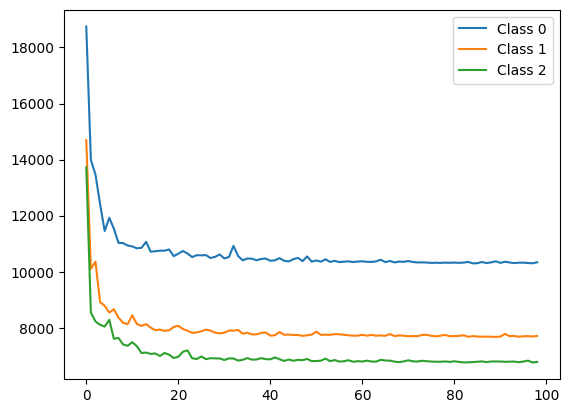

In [20]:
# Plot the scores
for i in range(3):
    # starting at the second iteration because the first is always huge
    pyplot.plot(svm_scores[i][1:], label='Class %d' % i)
pyplot.legend()

In [27]:
np.save('svm_weights_poly3.npy', w)
with open('svm_polynomial_features_poly3.pkl', 'wb') as file:
    pickle.dump(poly, file)